In [10]:
import os
import numpy as np
import tensorflow as tf
import keras
from scipy import misc, ndimage
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [12]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'elephant'], batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog', 'elephant'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog', 'elephant'], batch_size=10)

Found 722 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


In [13]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [14]:
imgs, labels = next(train_batches)

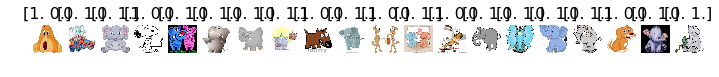

In [15]:
plots(imgs, titles=labels)

In [16]:
model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
                   Flatten(),
                   Dense(2, activation='softmax'),
                ])

In [17]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 6s - loss: 10.6782 - acc: 0.3375 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 0s - loss: 7.4546 - acc: 0.5375 - val_loss: 6.8380 - val_acc: 0.5758
Epoch 3/5
 - 0s - loss: 7.8586 - acc: 0.5125 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 4/5
 - 0s - loss: 9.2679 - acc: 0.4250 - val_loss: 9.2801 - val_acc: 0.4242
Epoch 5/5
 - 0s - loss: 8.4620 - acc: 0.4750 - val_loss: 8.0590 - val_acc: 0.5000


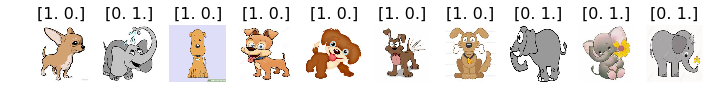

In [19]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [20]:
test_labels = test_labels[:, 0]
test_labels

array([1., 0., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

In [21]:
predictions = model.predict_generator(test_batches, steps=1, verbose=2)

In [22]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [23]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[0 4]
 [0 6]]


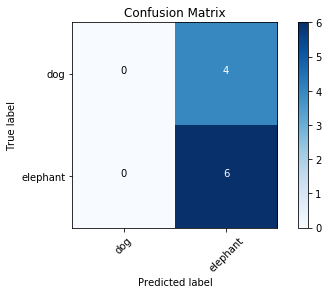

In [25]:
cm_plot_labels = ['dog', 'elephant']
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [26]:
vgg16_model = keras.applications.vgg16.VGG16()

In [27]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
type(vgg16_model)

keras.engine.training.Model

In [29]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    convout = layer
    model.add(layer)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [31]:
for layer in model.layers:
    layer.trainable = False

In [32]:
model.add(Dense(2, activation='softmax'))

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [34]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=50, verbose=2)

Epoch 1/50
 - 1s - loss: 0.9588 - acc: 0.5000 - val_loss: 0.7063 - val_acc: 0.6667
Epoch 2/50
 - 1s - loss: 0.8533 - acc: 0.5375 - val_loss: 0.9656 - val_acc: 0.5152
Epoch 3/50
 - 1s - loss: 0.7795 - acc: 0.6165 - val_loss: 0.7533 - val_acc: 0.6500
Epoch 4/50
 - 1s - loss: 0.6738 - acc: 0.6625 - val_loss: 0.6043 - val_acc: 0.6667
Epoch 5/50
 - 1s - loss: 0.9008 - acc: 0.6000 - val_loss: 0.8037 - val_acc: 0.5750
Epoch 6/50
 - 1s - loss: 0.8893 - acc: 0.4750 - val_loss: 0.8111 - val_acc: 0.4848
Epoch 7/50
 - 1s - loss: 0.6746 - acc: 0.6625 - val_loss: 0.6333 - val_acc: 0.7000
Epoch 8/50
 - 1s - loss: 0.7557 - acc: 0.5750 - val_loss: 0.4525 - val_acc: 0.8182
Epoch 9/50
 - 1s - loss: 0.7008 - acc: 0.6625 - val_loss: 0.8301 - val_acc: 0.5455
Epoch 10/50
 - 1s - loss: 0.5681 - acc: 0.7250 - val_loss: 0.4791 - val_acc: 0.7000
Epoch 11/50
 - 1s - loss: 0.6658 - acc: 0.6625 - val_loss: 0.6938 - val_acc: 0.6667
Epoch 12/50
 - 1s - loss: 0.7842 - acc: 0.5290 - val_loss: 0.5397 - val_acc: 0.7000
E

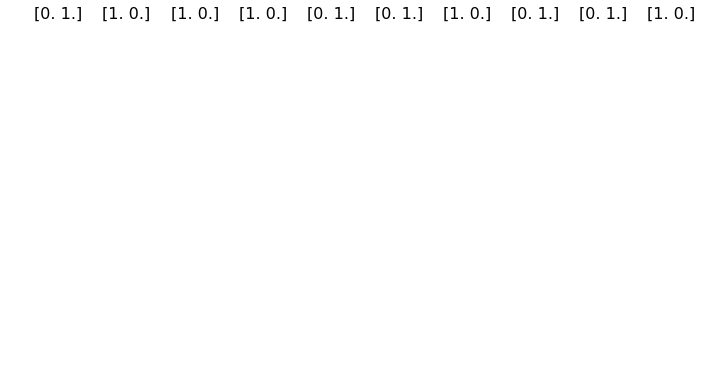

In [49]:
test_images, test_labels = next(test_batches)
plots(test_images, titles=test_labels)

In [44]:
test_labels = test_labels[:, 0]
test_labels

array([1., 0., 0., 0., 1., 1., 0., 1., 1., 0.], dtype=float32)

In [45]:
predictions = model.predict_generator(test_batches, steps = 1, verbose=0)

In [46]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[4 1]
 [0 5]]


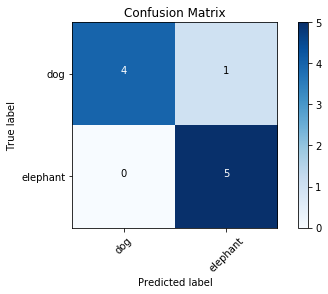

In [47]:
cm_plot_labels = ['dog', 'elephant']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [48]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
plt.imshow(ims[i], interpolation=None if interp else 'none')

NameError: name 'ims' is not defined

In [ ]:
plot_images(images=test_images, cls_true=test_labels, smooth=True)

In [ ]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True)

In [ ]:
image_path='train/dog/pic_071.jpg'

In [ ]:
image = np.expand_dims(ndimage.imread(image_path),0)
plt.imshow(image[0])

In [ ]:
aug_iter = gen.flow(image)

In [ ]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [ ]:
plots(aug_images, figsize=(20, 7), rows=2)

In [ ]:
test_batches.class_indices #the index where one is

In [ ]:
model.layers[0].get_config() # view details of intermediate layers

In [ ]:
model.count_params() #total number of parameters in the model

In [ ]:
model.layers[0].count_params() #number of parameters in intermediate layers

In [ ]:
model.layers[2].count_params()

In [ ]:
def plot_filters(layer, x, y):
    filters = layer.W.get_value()
    fig = plt.figure()
    for j in range(len(filters)):
        ax = fig.add_subplot(y, x, j+1)
        ax.matshow(filters[j][0], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt


In [ ]:
plot_filters(model.layers[3],8,4)


In [ ]:
model.layers[0].kernel